Student Submission Details:
* Name:
* Section:
* Schedule:
* Instructor:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=975fe2bf0238aad0871d1f9558e1161d303ef73b80de533b0f1f884e1ea57eea
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

video_capture = cv2.VideoCapture(0)

# Check if camera opened successfully
if not video_capture.isOpened():
    print("Error opening video stream or file")
    exit()

while True:
    ret, frame = video_capture.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2_imshow(frame) # Changed to cv2_imshow for Google Colab

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

Error opening video stream or file
Can't receive frame (stream end?). Exiting ...


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from deepface import DeepFace
import cv2
import numpy as np
import PIL
import io
import html
import time

24-11-10 14:17:21 - Directory /root/.deepface has been created
24-11-10 14:17:21 - Directory /root/.deepface/weights has been created


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):

  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))

In [ ]:
# Webcam

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# WEBCAM IMAGE
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # get smile coord using Haar cascade
  smiles = smile_cascade.detectMultiScale(gray, 1.8, 20)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image


  cv2.imwrite(filename, img)

  return filename

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(480, 640)
Saved to known.jpg


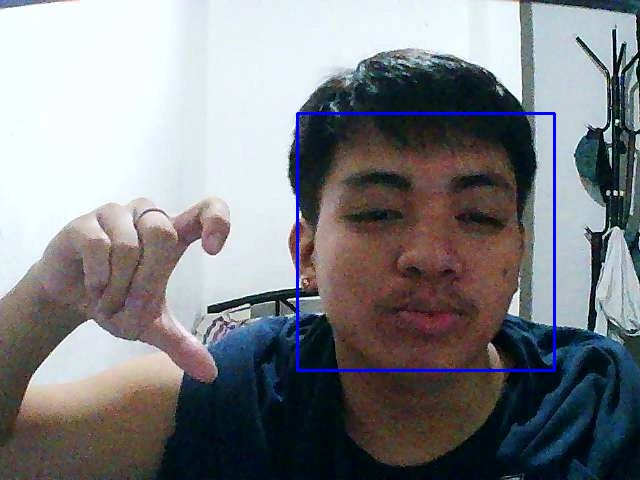

In [ ]:
try:
  filename = take_photo('known.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


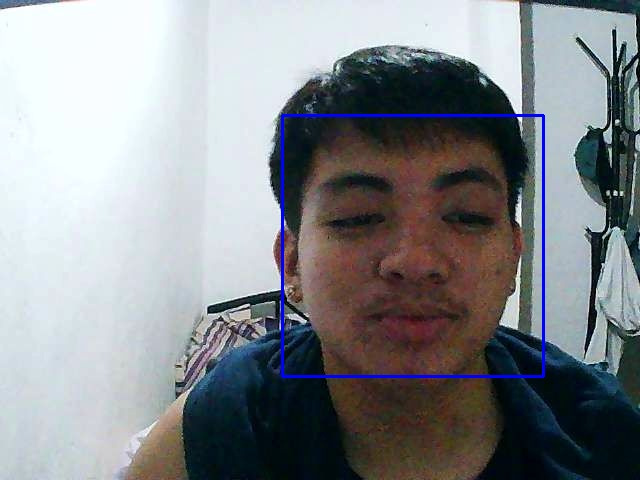

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Face Recognition

In [ ]:
!pip3 install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=55cdc2812d24290cb43f275fe5c1c69af81ca311da33f6fab58806883aa9a2b5
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from deepface import DeepFace
import cv2
import numpy as np
import PIL
import io
import html
import time
import face_recognition

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))

known_face_image = face_recognition.load_image_file("/content/known.jpg")
known_face_encoding = face_recognition.face_encodings(known_face_image)[0]


In [ ]:
# Webcam

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# WEBCAM IMAGE
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(rgb_img)
    face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # Compare face with known face encoding
        matches = face_recognition.compare_faces([known_face_encoding], face_encoding)

        # Label detected face
        if matches[0]:
            label = "RENZ GWAPINGS"
            color = (0, 255, 0)  # Green for recognized face
        else:
            label = "Unknown"
            color = (0, 0, 255)  # Red for unknown face

        cv2.rectangle(img, (left, top), (right, bottom), color, 2)
        cv2.putText(img, label, (left, bottom + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Save and display the image
    cv2.imwrite(filename, img)
    return filename

In [ ]:
import face_recognition
import cv2
import numpy as np

# Load and encode the reference face image(s)
known_face_image = face_recognition.load_image_file("/content/known.jpg")
known_face_encodings = face_recognition.face_encodings(known_face_image)

if not known_face_encodings:
    print("No faces found in the reference image!")
    exit()  # Exit if no face is found in the reference image

# Use the first face encoding (in case there are multiple faces)
known_face_encoding = known_face_encodings[0]

# Start streaming video from webcam
video_stream()
# Label for video
label_html = 'Capturing...'
# Initialize bounding box to empty
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Get face region coordinates
    face_locations = face_recognition.face_locations(rgb_img)
    face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    # Initialize default label and color
    label = "Unknown"
    color = (0, 0, 255)  # Red color for unknown faces

    # Check if any faces are detected
    if face_locations:
        # Iterate over face locations and face encodings
        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            matches = face_recognition.compare_faces([known_face_encoding], face_encoding)

            if matches[0]:
                label = "RENZ GWAPINGS"
                color = (0, 255, 0)  # Green color for recognized faces

            # Draw rectangle and label
            cv2.rectangle(img, (left, bottom - 35), (right, bottom), color, cv2.FILLED)  # Background for text
            cv2.putText(img, label, (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 255, 255), 1)

            # Draw bounding box on the overlay
            bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), color, 2)

    # Create transparent alpha channel overlay
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # Update bbox so next frame gets new overlay
    bbox = bbox_bytes



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to detected.jpg


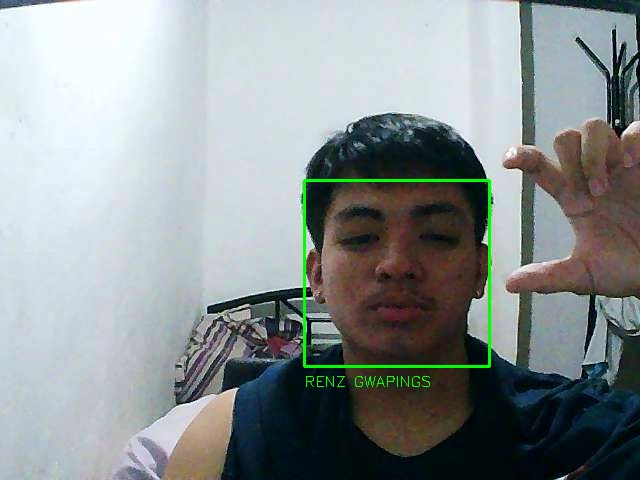

In [ ]:
try:
    filename = take_photo('detected.jpg')
    print('Saved to {}'.format(filename))
    display(Image(filename))
except Exception as err:
    print(str(err))

### Task 3: Mood Detection

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from deepface import DeepFace
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))

In [ ]:
# Webcam

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      result = DeepFace.analyze(img, actions=['emotion'])
      emotion = result[0]['dominant_emotion']

      cv2.rectangle(bbox_array,(x,y-40),(x+w,y),(255,0,0),-2)
      cv2.putText(bbox_array, emotion, (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255


    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

24-11-10 14:21:33 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 344MB/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to mood.jpg
Detected mood: happy


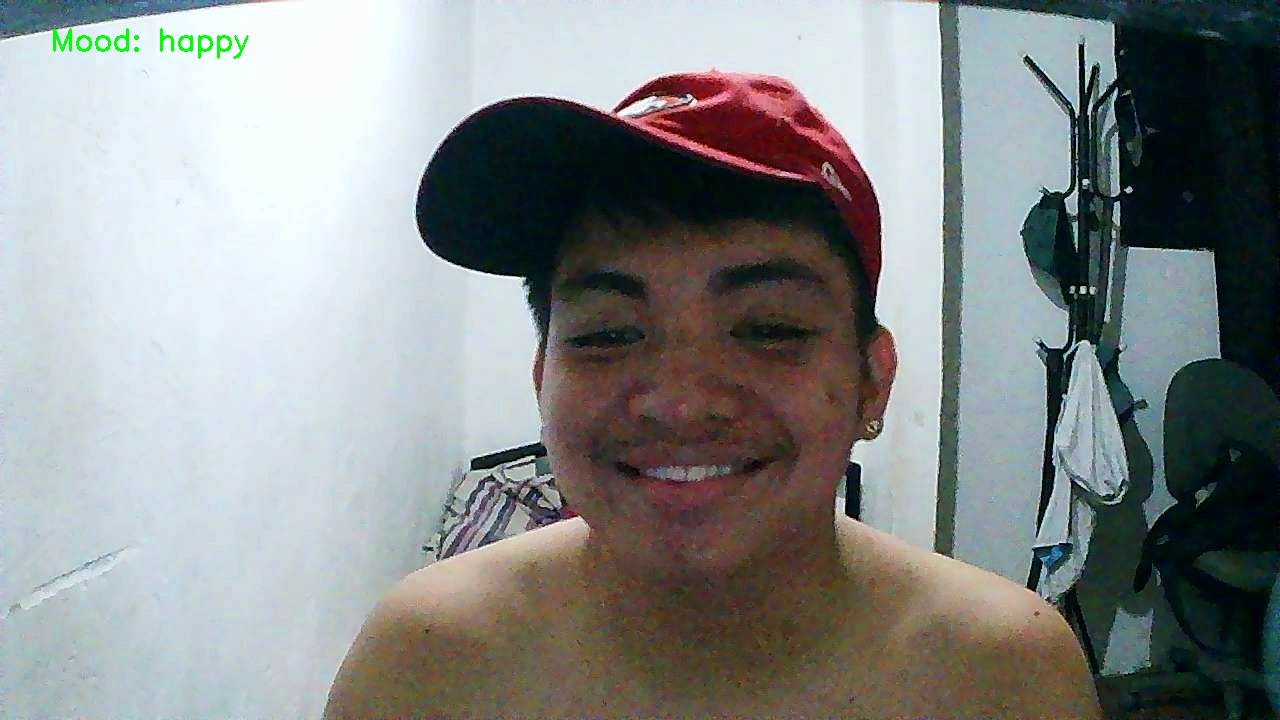

In [ ]:
from deepface import DeepFace

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    try:
        result = DeepFace.analyze(img, actions=['emotion'])
        dominant_emotion = result[0]['dominant_emotion']

        cv2.putText(img, f"Mood: {dominant_emotion}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imwrite(filename, img)
        return filename, dominant_emotion
    except Exception as err:
        print(f"Error analyzing emotion: {err}")
        cv2.imwrite(filename, img)
        return filename, None

video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_img)


    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    for (top, right, bottom, left) in face_locations:
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

try:
    filename, emotion = take_photo('mood.jpg')
    print('Saved to {}'.format(filename))
    if emotion:
        print(f"Detected mood: {emotion}")
    display(Image(filename))
except Exception as err:
    print(str(err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to mood.jpg
Detected mood: sad


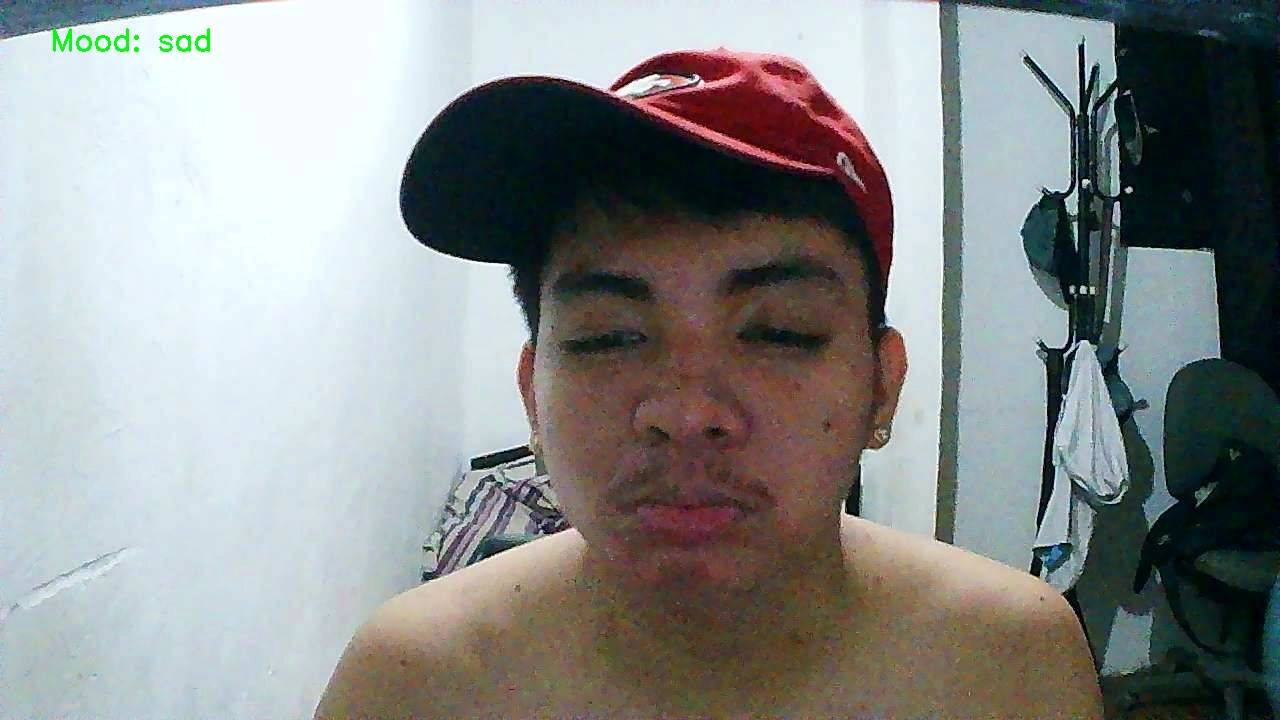

In [ ]:
from deepface import DeepFace

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    try:
        result = DeepFace.analyze(img, actions=['emotion'])
        dominant_emotion = result[0]['dominant_emotion']

        cv2.putText(img, f"Mood: {dominant_emotion}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imwrite(filename, img)
        return filename, dominant_emotion
    except Exception as err:
        print(f"Error analyzing emotion: {err}")
        cv2.imwrite(filename, img)
        return filename, None

video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_img)


    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    for (top, right, bottom, left) in face_locations:
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

try:
    filename, emotion = take_photo('mood.jpg')
    print('Saved to {}'.format(filename))
    if emotion:
        print(f"Detected mood: {emotion}")
    display(Image(filename))
except Exception as err:
    print(str(err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to mood.jpg
Detected mood: neutral


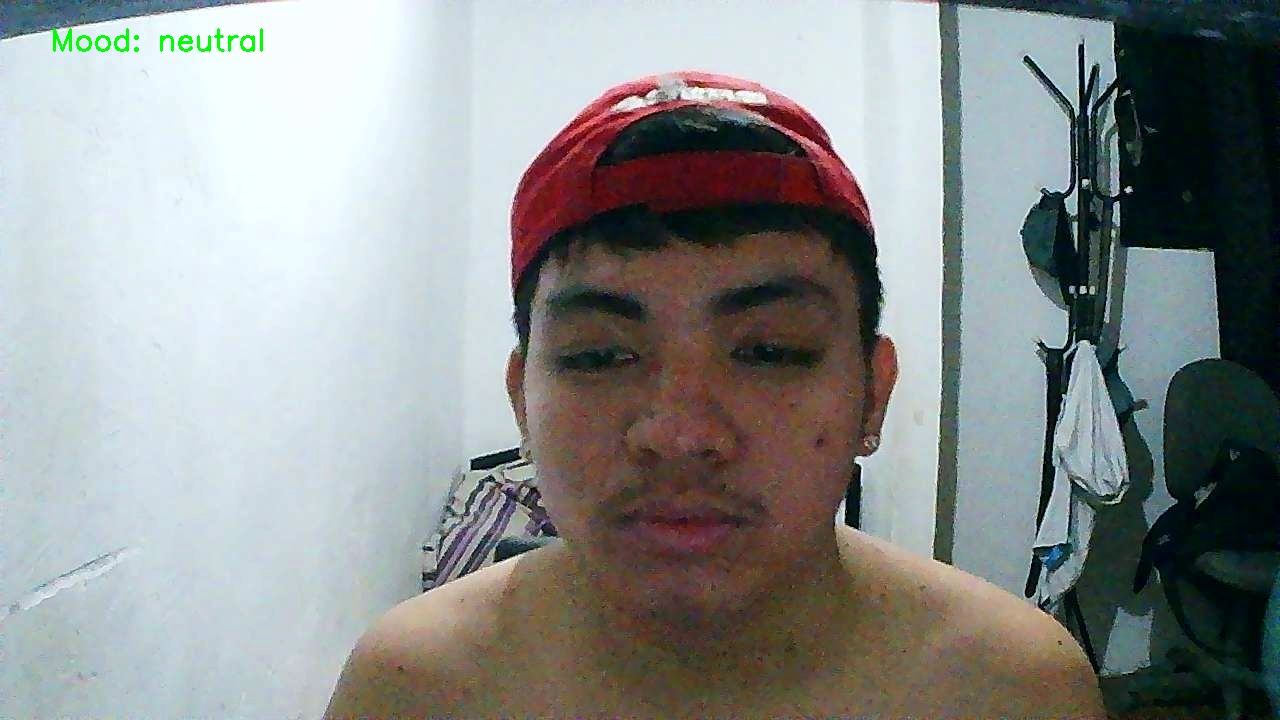

In [ ]:
from deepface import DeepFace

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    try:
        result = DeepFace.analyze(img, actions=['emotion'])
        dominant_emotion = result[0]['dominant_emotion']

        cv2.putText(img, f"Mood: {dominant_emotion}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imwrite(filename, img)
        return filename, dominant_emotion
    except Exception as err:
        print(f"Error analyzing emotion: {err}")
        cv2.imwrite(filename, img)
        return filename, None

video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_img)


    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    for (top, right, bottom, left) in face_locations:
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

try:
    filename, emotion = take_photo('mood.jpg')
    print('Saved to {}'.format(filename))
    if emotion:
        print(f"Detected mood: {emotion}")
    display(Image(filename))
except Exception as err:
    print(str(err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to mood.jpg
Detected mood: angry


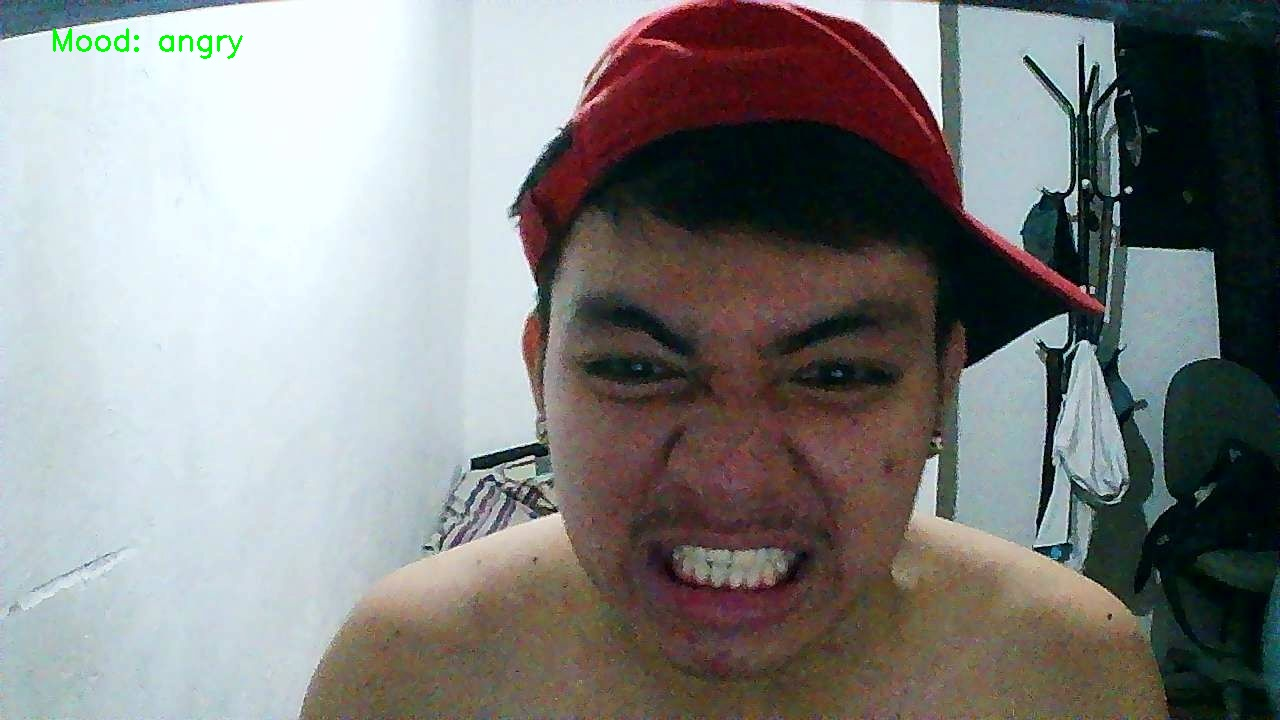

In [ ]:
from deepface import DeepFace

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)
    try:
        result = DeepFace.analyze(img, actions=['emotion'])
        dominant_emotion = result[0]['dominant_emotion']

        cv2.putText(img, f"Mood: {dominant_emotion}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imwrite(filename, img)
        return filename, dominant_emotion
    except Exception as err:
        print(f"Error analyzing emotion: {err}")
        cv2.imwrite(filename, img)
        return filename, None

video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(rgb_img)


    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    for (top, right, bottom, left) in face_locations:
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

try:
    filename, emotion = take_photo('mood.jpg')
    print('Saved to {}'.format(filename))
    if emotion:
        print(f"Detected mood: {emotion}")
    display(Image(filename))
except Exception as err:
    print(str(err))

---

---

## Summary and Lessons Learned

This assignment showed how computer vision can be used with tools like OpenCV, Deepface, and face_recognition to find faces, know who they are, and understand their emotions. The program could find faces in photos and videos and draw boxes around them using OpenCV, which helps with face detection. It could also recognize if a face was known or not using face_recognition, a tool for telling faces apart. The program could guess how someone was feeling like happy, sad, or neutral by using Deepface, which looks at facial expressions. The code was written in a clear and simple way, making it easy to read and change. Overall, this activity showed how useful computer vision is for learning from images, especially when it comes to faces and emotions.

---

**Proprietary Clause**

Property of the Technological Institute of the Philippines (T.I.P.). No part of the materials made and uploaded in this learning management system by T.I.P. may be copied, photographed, printed, reproduced, shared, transmitted, translated or reduced to any electronic medium or machine-readable form, in whole or in part, without prior consent of T.I.P.

Prepared by Engr. RMR